In [1]:
category_path = 'upper_pattern_img/'
category_list = ['check', 'dot', 'printed', 'simple', 'stripe']

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torch.utils.data
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from PIL import Image


In [3]:
dataset=[]
for category in category_list:
  img_list = os.listdir(category_path + category)
  print(len(img_list), category)
  for img in img_list:
    dataset.append([category_path + category + '/' + img, category])

683 check
602 dot
694 printed
892 simple
783 stripe


In [4]:
print(len(dataset))

3654


In [5]:
#for data balancing

count = 600
num_train = 520
num_valid = 70

random.seed(10)

train_data = []
valid_data = []
test_data = []


data_per_cat = {}
balanced_data = []
for category in category_list:
  data_per_cat[category] = [x for x in dataset if x[1] == category]
  balanced_data =balanced_data + random.sample(data_per_cat[category], count)

print(len(balanced_data))
for category in category_list:
  train_data = train_data + [x for x in balanced_data if x[1] == category][:num_train]
  valid_data = valid_data + [x for x in balanced_data if x[1] == category][num_train:num_train + num_valid]
  test_data = test_data + [x for x in balanced_data if x[1] == category][num_train + num_valid:count]
  
random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

print(len(train_data), len(valid_data), len(test_data))

3000
2600 350 50


In [6]:
class upper_category_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transforms = None):
    self.dataset = dataset
    self.transforms = transforms
  def __getitem__ (self, idx):
    img_path = os.path.join(self.dataset[idx][0])
    img = Image.open(img_path).convert("RGB")
    
    label = category_list.index(self.dataset[idx][1])
    
    if self.transforms is not None:
      img = self.transforms(img)

    return img, label

  def __len__(self):
    return len(self.dataset)


In [7]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])



In [8]:
train_dataset = upper_category_dataset(train_data, train_transforms)
valid_dataset = upper_category_dataset(valid_data, val_transforms)
test_dataset = upper_category_dataset(test_data, val_transforms)

print(len(train_dataset))


2600


In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 8, shuffle = False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, shuffle = False, num_workers=4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

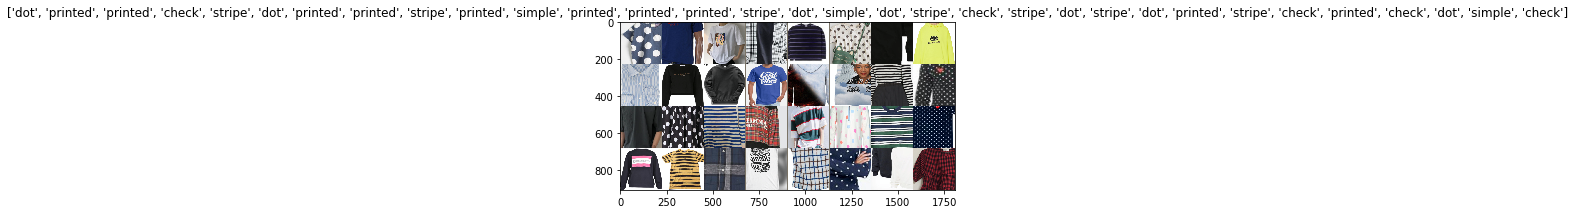

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)
imshow(out, title = [category_list[x] for x in classes])


In [11]:
def train_model(model, criterion, optimizer, scheduler, model_name, num_epochs=25):
  since = time.time()

  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)


    running_train_loss = 0.0
    running_train_corrects = 0
    running_val_loss = 0.0
    running_val_corrects = 0


    for i, data in enumerate(train_loader):
      inputs, labels = data
      model.train()
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      running_train_loss += loss.item()*inputs.size(0)
      running_train_corrects += torch.sum(preds == labels.data)

      if(i % 100 == 0):
        print("running training loss: {:.4f}".format(loss))
      
    for inputs, labels in valid_loader:
      model.eval()
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      running_val_loss += loss.item()*inputs.size(0)
      running_val_corrects += torch.sum(preds == labels.data)


    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_acc = running_train_corrects.double()/len(train_dataset) 
    epoch_val_loss = running_val_loss / len(valid_dataset)
    epoch_val_acc = running_val_corrects.double()/len(valid_dataset)

    if epoch_val_acc > best_acc:
      best_acc = epoch_val_acc
      best_model = copy.deepcopy(model.state_dict())
      path = 'models/'
      torch.save(model.state_dict(),path+model_name+'_'+str('{:.4f}'.format(best_acc)) + '.pth')
    
    print('Training: Loss: {:.4f} Acc: {:.4f} || Valid: Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc))

    scheduler.step()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model)

  return model




In [12]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,'resnet50_SGD',
                       num_epochs=50)

Epoch 0/49
----------
running training loss: 0.2828
Training: Loss: 0.3083 Acc: 0.9115 || Valid: Loss: 0.2268 Acc: 0.9371
Epoch 1/49
----------
running training loss: 0.2229
Training: Loss: 0.2813 Acc: 0.9215 || Valid: Loss: 0.2148 Acc: 0.9371
Epoch 2/49
----------
running training loss: 0.6043
Training: Loss: 0.2454 Acc: 0.9246 || Valid: Loss: 0.2218 Acc: 0.9229
Epoch 3/49
----------
running training loss: 0.2051
Training: Loss: 0.1904 Acc: 0.9388 || Valid: Loss: 0.2126 Acc: 0.9400
Epoch 4/49
----------
running training loss: 0.2056
Training: Loss: 0.1950 Acc: 0.9369 || Valid: Loss: 0.2030 Acc: 0.9343
Epoch 5/49
----------
running training loss: 0.2510
Training: Loss: 0.1577 Acc: 0.9508 || Valid: Loss: 0.2367 Acc: 0.9371
Epoch 6/49
----------
running training loss: 0.3508
Training: Loss: 0.1501 Acc: 0.9569 || Valid: Loss: 0.2176 Acc: 0.9429
Epoch 7/49
----------
running training loss: 0.0464
Training: Loss: 0.1533 Acc: 0.9485 || Valid: Loss: 0.2141 Acc: 0.9429
Epoch 8/49
----------
ru

KeyboardInterrupt: 